In [1]:
!pip -q install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 21.8 MB/s eta 0:00:00


In [2]:
#|export
from __future__ import annotations
import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl, numpy as np,matplotlib.pyplot as plt
from pathlib import Path
from operator import itemgetter
from itertools import zip_longest
import fastcore.all as fc

from torch import tensor,optim,nn
from torch.utils.data import DataLoader,default_collate
import torch.nn.functional as F

from datasets import load_dataset, load_dataset_builder

In [3]:
import torchvision.transforms.functional as TF
from fastcore.test import test_close

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray'

In [4]:
import logging
logging.disable(logging.WARNING)

Hugging Face Datasets

In [5]:
name = "fashion_mnist"
ds_builder = load_dataset_builder(name)
print(ds_builder.info.description)

Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of
60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image,
associated with a label from 10 classes. We intend Fashion-MNIST to serve as a direct drop-in
replacement for the original MNIST dataset for benchmarking machine learning algorithms.
It shares the same image size and structure of training and testing splits.



In [6]:
ds_builder.info.features

{'image': Image(decode=True, id=None),
 'label': ClassLabel(names=['T - shirt / top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'], id=None)}

In [7]:
ds_builder.info.splits

{'train': SplitInfo(name='train', num_bytes=31296655, num_examples=60000, shard_lengths=None, dataset_name=None),
 'test': SplitInfo(name='test', num_bytes=5233818, num_examples=10000, shard_lengths=None, dataset_name=None)}

In [8]:
dsd = load_dataset(name)
dsd

Extracting data files:   0%|          | 0/4 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 60000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})

In [9]:
train,test = dsd['train'],dsd['test']
train[0]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28>,
 'label': 9}

In [10]:
# you can get the x, y image and label from the info.features
x,y = ds_builder.info.features
x,y

('image', 'label')

In [11]:
x,y = 'image', 'label'
img = train[0][x]
img

In [12]:
xb = train[:5][x]
yb = train[:5][y]
yb

[9, 0, 0, 3, 0]

In [13]:
featy = train.features[y]
featy

ClassLabel(names=['T - shirt / top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'], id=None)

In [14]:
featy.int2str(yb)

['Ankle boot',
 'T - shirt / top',
 'T - shirt / top',
 'Dress',
 'T - shirt / top']

In [15]:
train['label'][:5]

[9, 0, 0, 3, 0]

In [16]:
def collate_fn(b):
  return {x:torch.stack([TF.to_tensor(o[x]) for o in b]),
          y:tensor([o[y] for o in b])}

In [17]:
dl = DataLoader(train, collate_fn=collate_fn, batch_size=16)
b = next(iter(dl))
b[x].shape, b[y]

(torch.Size([16, 1, 28, 28]),
 tensor([9, 0, 0, 3, 0, 2, 7, 2, 5, 5, 0, 9, 5, 5, 7, 9]))

In [18]:
def transforms(b):
  b[x] = [TF.to_tensor(o) for o in b[x]]
  return b

In [19]:
tds = train.with_transform(transforms)
dl = DataLoader(tds, batch_size=16)
b = next(iter(dl))
b[x].shape, b[y]

(torch.Size([16, 1, 28, 28]),
 tensor([9, 0, 0, 3, 0, 2, 7, 2, 5, 5, 0, 9, 5, 5, 7, 9]))

In [20]:
def _transformi(b): b[x] = [torch.flatten(TF.to_tensor(o)) for o in b[x]]

In [21]:
def inplace(f):
  def _f(b):
    f(b)
    return b
  return _f

In [22]:
transformi = inplace(_transformi)

In [24]:
r= train.with_transform(transformi)[0]
r[x].shape, r[y]

(torch.Size([784]), 9)

In [25]:
@inplace
def transformi(b): b[x] = [torch.flatten(TF.to_tensor(o)) for o in b[x]]

In [27]:
tdsf = train.with_transform(transformi)
r = tdsf[0]
r[x].shape, r[y]

(torch.Size([784]), 9)

In [29]:
batch = dict(a=[1],b=[2]),dict(a=[3],b=[4])
default_collate(batch)

{'a': [tensor([1, 3])], 'b': [tensor([2, 4])]}

In [31]:
def collate_dict(ds):
  get = itemgetter(*ds.features)
  def _f(b): return get(default_collate(b))
  return _f

In [35]:
dlf = DataLoader(tdsf, batch_size=4, collate_fn=collate_dict(tdsf))
xb,yb = next(iter(dlf))
yb.shape, yb

(torch.Size([4]), tensor([9, 0, 0, 3]))

Plotting images


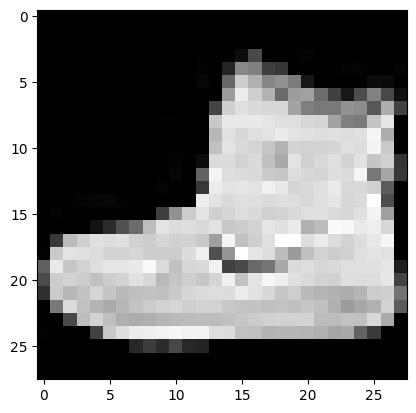

In [40]:
b = next(iter(dl))
xb = b['image']
img = xb[0]
plt.imshow(img[0]);

In [41]:
@fc.delegates(plt.Axes.imshow)
def show_image(im,ax=None, figsize=None, title=None, **kwargs):
  "show a PIL or Pytorch image in `ax`."
  if fc.hasattrs(im, ('cpu', 'permute')):
    im = im.cpu()
    if im.shape[0]<5: im=im.permute(1,2,0)
  elif not isinstance(im,np.adarray):im=np.array(im)
  if im.shape[-1]==1:im=im[...,0]
  if ax is None: _,ax = plt.subplots(figsize=figsize)
  ax.imshow(im,**kwargs)
  if title is not None: ax.set_titel(title)
  ax.axis('off')
  return ax

In [42]:
help(show_image)

Help on function show_image in module __main__:

show_image(im, ax=None, figsize=None, title=None, *, cmap=None, norm=None, aspect=None, interpolation=None, alpha=None, vmin=None, vmax=None, origin=None, extent=None, interpolation_stage=None, filternorm=True, filterrad=4.0, resample=None, url=None, data=None)
    show a PIL or Pytorch image in `ax`.



<Axes: >

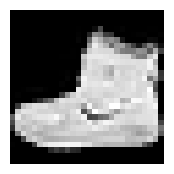

In [51]:
show_image(img, figsize=(2,2))